# **This code implements a Variational Autoencoder (VAE) for the MNIST dataset using PyTorch. The VAE model consists of an encoder that maps the input image to a latent representation, and a decoder that reconstructs the input image from the latent representation. The model is trained by minimizing the reconstruction loss and the KL divergence between the latent distribution and the prior distribution.**


[Colab link](https://colab.research.google.com/drive/19imVdJ95MzO8XQEvZFw_hDNVs6_4n65B#scrollTo=RKBSuBhJw92m)

Import the necessary PyTorch modules and the torchvision module for loading and preprocessing the MNIST dataset.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

Define the hyperparameters for the VAE model: batch size, latent dimension, number of epochs, and the device (GPU if available, otherwise CPU) on which to run the computations.

In [11]:
# Hyperparameters
batch_size = 128
latent_dim = 20
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Load the MNIST dataset from the './data' directory, convert the images to PyTorch tensors using transforms.ToTensor(), and create a data loader for iterating over the dataset in batches of size batch_size with shuffling enabled.

In [12]:
# Load and preprocess MNIST dataset
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(mnist, batch_size=batch_size, shuffle=True)

Define VAE model class, which inherits from nn.Module. The __init__ method initializes the model with the specified latent_dim.

Define the encoder part of the VAE model. The encoder consists of two convolutional layers, followed by a flatten operation and a fully connected layer. The output of the encoder is then passed through two separate fully connected layers to produce the mean (mu) and log variance (log_var) of the latent distribution.

 **Encoder:**

**Convolutional Layer 1:**

Input: 1 channel (grayscale MNIST images)
Output: 32 channels
Kernel Size: 3x3
Stride: 2
Padding: 1
Activation: ReLU
Output Size: (batch_size, 32, 14, 14)

**Convolutional Layer 2:**

Input: 32 channels
Output: 64 channels
Kernel Size: 3x3
Stride: 2
Padding: 1
Activation: ReLU
Output Size: (batch_size, 64, 7, 7)

**Flatten Layer:**

Flattens the output from the previous convolutional layer
Output Size: (batch_size, 64 * 7 * 7)

**Linear Layer (Hidden):**

Input: 64 * 7 * 7
Output: 256
Activation: ReLU
Output Size: (batch_size, 256)

**Mean (mu) Layer:**

Linear transformation from the hidden layer to the latent space mean
Input: 256
Output: latent_dim
Output Size: (batch_size, latent_dim)

**Log Variance (log_var) Layer:**

Linear transformation from the hidden layer to the latent space log variance
Input: 256
Output: latent_dim
Output Size: (batch_size, latent_dim)

**Decoder:**

**Linear Layer (Hidden):**

Input: latent_dim
Output: 256
Activation: ReLU
Output Size: (batch_size, 256)

**Linear Layer (Upsampling):**

Input: 256
Output: 64 * 7 * 7
Activation: ReLU
Output Size: (batch_size, 64 * 7 * 7)

**Reshape Layer:**

Reshapes the output from the previous linear layer into a 4D tensor
Output Size: (batch_size, 64, 7, 7)

**Transposed Convolutional Layer 1:**

Input: 64 channels
Output: 32 channels
Kernel Size: 3x3
Stride: 2
Padding: 1
Output Padding: 1
Activation: ReLU
Output Size: (batch_size, 32, 14, 14)

**Transposed Convolutional Layer 2:**

Input: 32 channels
Output: 1 channel
Kernel Size: 3x3
Stride: 2
Padding: 1
Output Padding: 1
Activation: Sigmoid
Output Size: (batch_size, 1, 28, 28)

**Summary:**

-The encoder reduces the spatial dimensions of the input MNIST images while increasing the number of channels.

-The decoder upsamples the latent space representation to reconstruct the original size of the MNIST images.

-The final output from the decoder represents the reconstructed MNIST images with pixel values constrained between 0 and 1, suitable for grayscale images.

In [13]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU()
        )
        self.mu = nn.Linear(256, latent_dim)
        self.log_var = nn.Linear(256, latent_dim)


        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Add Sigmoid activation to ensure output values are between 0 and 1
        )


    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = self.mu(h), self.log_var(h)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var

This method implements the reparameterization trick used in VAEs to sample from the latent distribution during training.

This is the forward pass of the VAE model. It takes the input image x, passes it through the encoder to obtain the mean and log variance of the latent distribution, samples a latent representation z using the reparameterization trick, and then passes z through the decoder to reconstruct the input image. The method returns the reconstructed image (x_recon), the mean (mu), and the log variance (log_var).

In [14]:
# Instantiate the model
model = VAE(latent_dim).to(device)

This line instantiates the VAE model with the specified latent_dim and moves it to the appropriate device (GPU or CPU).

**Loss function for the VAE model**.

It consists of two parts: the reconstruction loss (binary cross-entropy between the reconstructed image and the input image) and the Kullback-Leibler (KL) divergence between the latent distribution and the prior distribution (which is a standard normal distribution in this case).

optimizer (Adam) is used for updating the model parameters during training, with a learning rate of 1e-3.

In [15]:


# Define the loss function
def loss_function(x_recon, x, mu, log_var):
    reconstruction_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



**Training loop for the VAE model.**
It iterates over the specified number of epochs and, for each batch of data, performs the following steps:

1) Move the input data (x) to the appropriate device.

2) Zero out the gradients from the previous iteration.

3) Pass the input data through the VAE model to obtain the reconstructed image (x_recon), mean (mu), and log variance (log_var).

4) Compute the loss using the loss_function.

5) Backpropagate the gradients of the loss.

6) Update the model parameters using the optimizer.

7) Print the current epoch, batch, and loss every 100 batches.

it saves the trained model's state dictionary (weights and biases) to a file named 'vae.pth'.

In [16]:
# Training loop
for epoch in range(epochs):
    for batch_idx, (x, _) in enumerate(data_loader):
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, mu, log_var = model(x)
        loss = loss_function(x_recon, x, mu, log_var)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch+1}/{epochs}, Batch: {batch_idx+1}/{len(data_loader)}, Loss: {loss.item() / batch_size:.4f}')

# Save the trained model
torch.save(model.state_dict(), 'vae.pth')

Epoch: 1/20, Batch: 1/469, Loss: 466.2633
Epoch: 1/20, Batch: 101/469, Loss: 198.7847
Epoch: 1/20, Batch: 201/469, Loss: 160.5827
Epoch: 1/20, Batch: 301/469, Loss: 154.4782
Epoch: 1/20, Batch: 401/469, Loss: 137.4309
Epoch: 2/20, Batch: 1/469, Loss: 123.8185
Epoch: 2/20, Batch: 101/469, Loss: 121.9520
Epoch: 2/20, Batch: 201/469, Loss: 118.6191
Epoch: 2/20, Batch: 301/469, Loss: 114.5827
Epoch: 2/20, Batch: 401/469, Loss: 109.4721
Epoch: 3/20, Batch: 1/469, Loss: 106.6530
Epoch: 3/20, Batch: 101/469, Loss: 112.6362
Epoch: 3/20, Batch: 201/469, Loss: 107.1552
Epoch: 3/20, Batch: 301/469, Loss: 102.1541
Epoch: 3/20, Batch: 401/469, Loss: 104.2223
Epoch: 4/20, Batch: 1/469, Loss: 111.3882
Epoch: 4/20, Batch: 101/469, Loss: 104.1933
Epoch: 4/20, Batch: 201/469, Loss: 104.2441
Epoch: 4/20, Batch: 301/469, Loss: 105.0988
Epoch: 4/20, Batch: 401/469, Loss: 105.2579
Epoch: 5/20, Batch: 1/469, Loss: 111.8313
Epoch: 5/20, Batch: 101/469, Loss: 103.0321
Epoch: 5/20, Batch: 201/469, Loss: 107.153

**Load the saved model weights:**

we first create an instance of the VAE model with the same latent_dim as the trained model. Then, we load the saved state dictionary (vae.pth) containing the trained weights and biases into the model using model.load_state_dict(torch.load('vae.pth')). Finally, we set the model to evaluation mode using model.eval().

In [17]:
# Load the saved model
model = VAE(latent_dim)
model.load_state_dict(torch.load('vae.pth'))
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=3136, out_features=256, bias=True)
    (6): ReLU()
  )
  (mu): Linear(in_features=256, out_features=20, bias=True)
  (log_var): Linear(in_features=256, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3136, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(64, 7, 7))
    (5): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (8): Sigmoid()
  )
)

**Generate random latent vectors:**

To generate new data samples, we first need to create random latent vectors. In this example, we generate num_samples (set to 10) random latent vectors of size latent_dim (set to 20 in the original code) using torch.randn.

In [18]:
# Generate random latent vectors
num_samples = 10  # Number of samples to generate
latent_vectors = torch.randn(num_samples, latent_dim).to(device)

**Pass the latent vectors through the decoder to generate new samples:**

We use the decoder part of the VAE model to generate new samples from the random latent vectors. We wrap the generation process with torch.no_grad() to disable gradient computation since we're only generating samples and not training the model. The generated samples are then moved to CPU and converted to NumPy arrays for further processing or visualization.

In [19]:
# Generate new samples
with torch.no_grad():
    generated_samples = model.decoder(latent_vectors).cpu().numpy()

**Visualize or process the generated samples:**

In this example, we use matplotlib to visualize the generated samples as grayscale images. The squeeze() function is used to remove the singleton dimensions from the generated samples, as they have an extra channel dimension due to the way the VAE model was designed.

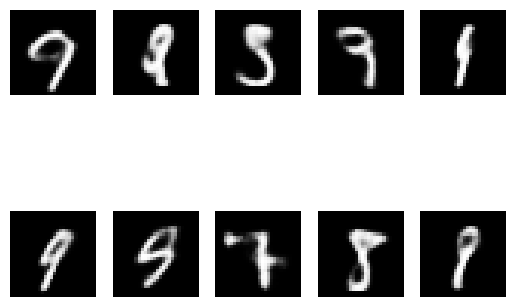

In [20]:
import matplotlib.pyplot as plt

# Visualize the generated samples
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_samples[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

By following these steps, you can generate new data samples using the trained VAE model. Note that the quality of the generated samples will depend on the performance of the trained model and the complexity of the data distribution.

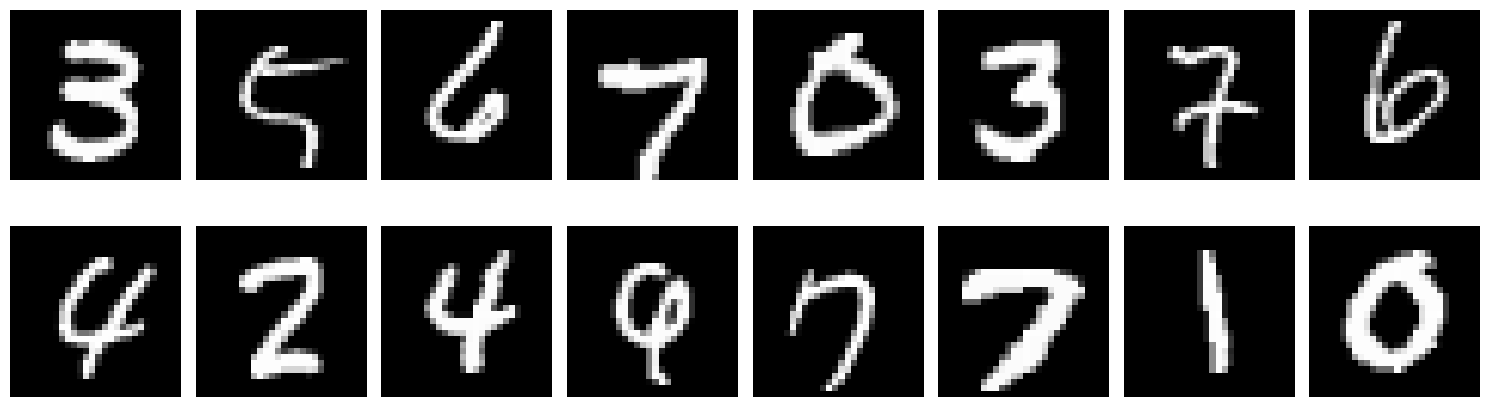

In [22]:

# Visualize training images
train_images = next(iter(data_loader))[0][:16]  # Get the first 16 images from the next batch

# Plot training images
fig, axs = plt.subplots(nrows=2, ncols=8, figsize=(15, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(train_images[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()



We visualize the first 16 training images from the next batch using matplotlib.

We generate 16 synthetic images by sampling random latent vectors and passing them through the decoder of the VAE model.

We visualize the synthetic images using matplotlib.
To check if the synthetic images are present in the original dataset, we first convert the original dataset images and the synthetic images to a common format (view(-1, 1, 28, 28)).

For each synthetic image, we calculate the absolute difference between the synthetic image and all the images in the original dataset, summed over all dimensions (diff = (dataset_images - synthetic_image).abs().sum(dim=(1, 2, 3))).

If the minimum value of diff is zero, it means that the synthetic image is exactly the same as one of the images in the original dataset, and we print a message indicating that the synthetic image is present in the original dataset.

If the minimum value of diff is non-zero, it means that the synthetic image is not present in the original dataset, and we print a message indicating that the synthetic image is not present in the original dataset.

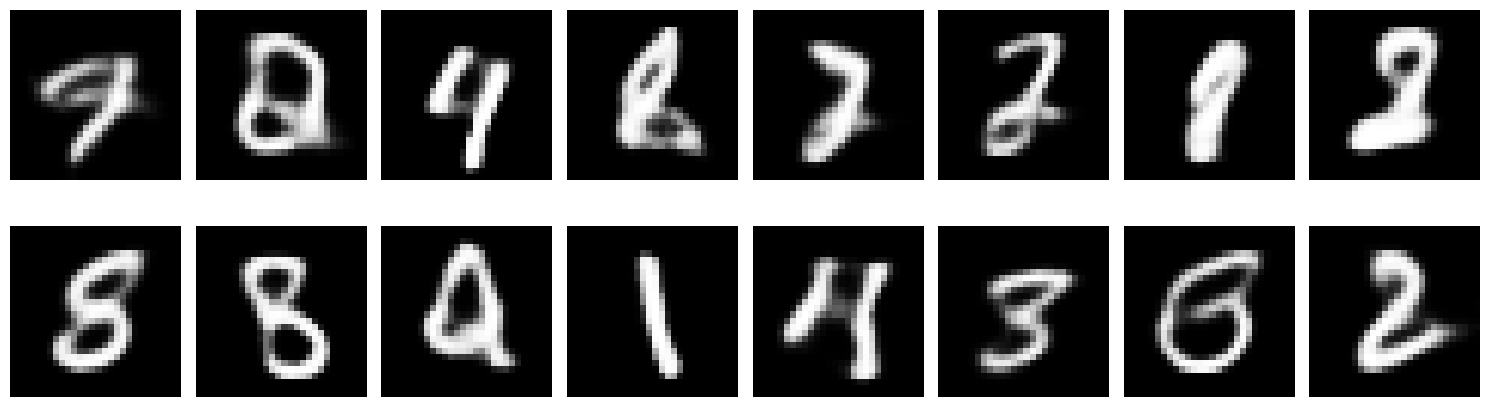

Synthetic image 0 is not present in the original dataset.
Synthetic image 1 is not present in the original dataset.
Synthetic image 2 is not present in the original dataset.
Synthetic image 3 is not present in the original dataset.
Synthetic image 4 is not present in the original dataset.
Synthetic image 5 is not present in the original dataset.
Synthetic image 6 is not present in the original dataset.
Synthetic image 7 is not present in the original dataset.
Synthetic image 8 is not present in the original dataset.
Synthetic image 9 is not present in the original dataset.
Synthetic image 10 is not present in the original dataset.
Synthetic image 11 is not present in the original dataset.
Synthetic image 12 is not present in the original dataset.
Synthetic image 13 is not present in the original dataset.
Synthetic image 14 is not present in the original dataset.
Synthetic image 15 is not present in the original dataset.


In [23]:
# Generate synthetic images
with torch.no_grad():
    latent_vectors = torch.randn(16, latent_dim).to(device)
    synthetic_images = model.decoder(latent_vectors).cpu()

# Plot synthetic images
fig, axs = plt.subplots(nrows=2, ncols=8, figsize=(15, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(synthetic_images[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Check if synthetic images are present in the original dataset
dataset_images = mnist.data.float().view(-1, 1, 28, 28) / 255.0
synthetic_images = synthetic_images.view(-1, 1, 28, 28)

for i, synthetic_image in enumerate(synthetic_images):
    diff = (dataset_images - synthetic_image).abs().sum(dim=(1, 2, 3))
    if diff.min() == 0:
        print(f"Synthetic image {i} is present in the original dataset.")
    else:
        print(f"Synthetic image {i} is not present in the original dataset.")